# Merge Datasets and Analysis

# General

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Constants

In [2]:
PATH_PROTECED_AREA = 'data/OECD/protected_areas_2020.csv'
PATH_LAND_COVER = 'data/OECD/LAND_COVER_2018_DATA.csv'
PATH_AIR = 'data/OECD/greenhouse_gases_2020_pred.csv'
PATH_CLIMATE = 'data/climate/climate_features.csv'
PATH_IUCN = 'data/IUCN/scraped'
PATH_IUCN_REL = 'data/IUCN/THREATENED_RELATIVE.csv'
PATHS_COUN = [PATH_PROTECED_AREA, PATH_LAND_COVER, PATH_CLIMATE, PATH_AIR] # AIR IS MISSING
RANDOM_STATE = 42

# IUCN Data

## Load and Concatenate

In [3]:
iucn_list = []
for _, _, files in os.walk(PATH_IUCN):
    for file in files:
        temp = pd.read_csv(PATH_IUCN + '/' + file)
        temp['Country'] = file.split('.csv')[0]
        iucn_list.append(temp)
iucn_data = pd.concat(iucn_list)

## Analysis

### General Information

In [4]:
iucn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136624 entries, 0 to 1128
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   kingdom_class    136624 non-null  object
 1   common_name      93221 non-null   object
 2   scientific_name  136624 non-null  object
 3   trend            133638 non-null  object
 4   region           136624 non-null  object
 5   threat_level     136624 non-null  object
 6   Country          136624 non-null  object
dtypes: object(7)
memory usage: 8.3+ MB


### Check Uniue Values

In [5]:
for c in iucn_data.columns:
    print('Column >>{}<< contains {} unique values.'.format(c, iucn_data[c].nunique()))

Column >>kingdom_class<< contains 32 unique values.
Column >>common_name<< contains 30138 unique values.
Column >>scientific_name<< contains 52327 unique values.
Column >>trend<< contains 4 unique values.
Column >>region<< contains 13 unique values.
Column >>threat_level<< contains 9 unique values.
Column >>Country<< contains 65 unique values.


### Explore Columns Containing NULL Values

#### common_name

In [6]:
print('common_name contains {} unique values.'.format(
    iucn_data['common_name'].nunique()))

common_name contains 30138 unique values.


In [7]:
print('{} entries have missing values for the common_name column.'.format(
    iucn_data['common_name'].isna().sum()))

43403 entries have missing values for the common_name column.


In [8]:
i_null_cn = iucn_data[iucn_data['common_name'].isna()].index

--> These missing values can probably be neglected, because we can use the scientific name as identifier.

#### trend

In [9]:
print('trend contains {} unique values, which are: {}.'.format(
    iucn_data['trend'].nunique(), iucn_data['trend'].unique()))

trend contains 4 unique values, which are: ['Unknown' 'Stable' 'Decreasing' nan 'Increasing'].


In [10]:
print('{} entries have missing values for the trend column.'.format(
    iucn_data['trend'].isna().sum()))

2986 entries have missing values for the trend column.


<AxesSubplot:>

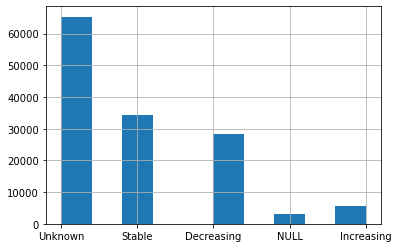

In [11]:
temp_iucn = iucn_data.copy()
temp_iucn.loc[temp_iucn['trend'].isna(), 'trend'] = 'NULL'
temp_iucn['trend'].hist()

In [12]:
print(
    'The dataset contains {} entries with available trend information (not Null or Unknown).'
    .format(
        len(iucn_data[(iucn_data['trend'].isna() == False)
                      & (iucn_data['trend'] != 'Unknown')])))

The dataset contains 68333 entries with available trend information (not Null or Unknown).


**NOTE: This is an issue and we have to think about a strategy how to deal with these missing/unknown values.**
Maybe we can check if these entries have some special characteristics.

# Country Characteristics Data

## Load and Merge

In [13]:
coun_list = []
country_sets = []
for file in PATHS_COUN:
    print(file)
    temp = pd.read_csv(file)
    coun_list.append(temp)
    country_sets.append(set(temp['Country']))

data/OECD/protected_areas_2020.csv
data/OECD/LAND_COVER_2018_DATA.csv
data/climate/climate_features.csv
data/OECD/greenhouse_gases_2020_pred.csv


In [14]:
intersect_countries = country_sets[0].intersection(
    country_sets[1], country_sets[2], country_sets[3])  ## add country_sets[3]
print(
    'The Country Characterisitcs Datasets contain {} intersecting countries, which are: {}'
    .format(len(intersect_countries), intersect_countries))

The Country Characterisitcs Datasets contain 42 intersecting countries, which are: {'Germany', 'France', 'Finland', 'United States', 'Austria', 'New Zealand', 'Slovenia', 'India', 'Korea', 'Ireland', 'Colombia', 'Italy', 'Norway', 'Switzerland', 'Latvia', 'Luxembourg', 'Sweden', 'Mexico', 'Denmark', 'Belgium', 'Estonia', 'Hungary', 'Iceland', 'Spain', 'Brazil', 'Canada', 'Australia', 'Poland', 'Russia', 'Israel', 'Lithuania', 'Japan', 'Greece', 'Chile', 'Netherlands', 'Costa Rica', 'Czech Republic', 'Slovak Republic', 'Argentina', 'Portugal', 'Indonesia', 'United Kingdom'}


--> Join Datasets on those countries.

In [15]:
coun_data = coun_list[0]
for coun in coun_list[1:]:
    coun_data = pd.merge(coun_data, coun, on='Country', how='inner')
coun_data.head()

,Country,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,perc_area_protected_obj_1a,perc_area_protected_obj_1b,perc_area_protected_no_obj,perc_area_protected_obj_5,perc_area_protected_obj_6,...,gain_percentage,temp_difference,Unnamed: 0,CH4,CO2,HFC,N2O,NF3,PFC,SF6
0,Argentina,8.39,1.84,0.04,0.19,0.27,0.03,1.46,0.33,4.09,...,0.500525,0.072246,0,1.828861,4.710241,0.014370,1.002114,-1.000000,0.003744,0.000042
1,Australia,19.20,4.17,0.24,0.27,2.01,0.57,0.34,0.98,10.63,...,0.969423,0.214683,1,4.382540,16.642911,0.479420,0.804808,-1.000000,0.009443,0.009144
2,Austria,28.54,2.38,0.01,5.80,0.01,0.12,4.62,15.35,0.20,...,24.241043,1.498389,2,0.728541,7.549433,0.207606,0.398982,0.001868,0.003680,0.043241
3,Belgium,24.97,0.07,0.00,1.54,0.00,0.00,9.19,12.59,1.59,...,12.044550,1.167659,3,0.688260,8.787278,0.391962,0.500037,0.000057,0.011516,0.008337
4,Brazil,29.80,4.13,0.07,0.03,2.06,0.00,11.83,4.58,6.78,...,3.703937,0.929317,4,1.683181,2.566549,-1.000000,0.894033,-1.000000,-1.000000,-1.000000


## Analysis

### General Information

In [16]:
coun_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      42 non-null     object 
 1   perc_area_protected_all_obj  42 non-null     float64
 2   perc_area_protected_obj_2    42 non-null     float64
 3   perc_area_protected_obj_3    42 non-null     float64
 4   perc_area_protected_obj_4    42 non-null     float64
 5   perc_area_protected_obj_1a   42 non-null     float64
 6   perc_area_protected_obj_1b   42 non-null     float64
 7   perc_area_protected_no_obj   42 non-null     float64
 8   perc_area_protected_obj_5    42 non-null     float64
 9   perc_area_protected_obj_6    42 non-null     float64
 10  Artificial surfaces          42 non-null     float64
 11  Bare area                    42 non-null     float64
 12  Cropland                     42 non-null     float64
 13  Grassland             

There are no missing values in the dataset.

In [17]:
coun_data.describe()

,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,perc_area_protected_obj_1a,perc_area_protected_obj_1b,perc_area_protected_no_obj,perc_area_protected_obj_5,perc_area_protected_obj_6,Artificial surfaces,...,gain_percentage,temp_difference,Unnamed: 0,CH4,CO2,HFC,N2O,NF3,PFC,SF6
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,22.282857,4.151667,0.362381,2.964762,0.445714,0.872619,6.900476,4.782381,1.533333,0.026339,...,10.864795,0.987359,22.095238,1.284412,7.478007,0.164214,0.586226,-0.666490,-0.154093,-0.036179
std,10.766357,5.984902,1.917474,3.469978,0.676599,1.827691,8.767212,5.999103,2.741055,0.027342,...,12.305045,0.448411,12.957359,1.194647,4.017188,0.297642,0.349903,0.477372,0.384327,0.219119
min,5.640000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-24.178355,0.072246,0.000000,0.236113,1.278950,-1.000000,0.092906,-1.000000,-1.000000,-1.000000
25%,14.287500,0.652500,0.000000,0.440000,0.000000,0.000000,0.472500,0.110000,0.000000,0.005924,...,3.832235,0.659961,11.250000,0.750174,4.848182,0.109285,0.345235,-1.000000,0.000021,0.002429
50%,20.370000,2.025000,0.020000,1.555000,0.070000,0.005000,3.375000,1.430000,0.085000,0.015773,...,9.547614,0.943211,22.500000,0.893499,6.846338,0.176891,0.481730,-1.000000,0.003712,0.007283
75%,27.892500,4.812500,0.070000,3.877500,0.545000,0.525000,11.290000,7.780000,1.552500,0.040661,...,17.897105,1.382112,32.750000,1.261372,9.078078,0.322812,0.849686,0.000009,0.012341,0.010464
max,53.530000,32.610000,12.470000,14.740000,2.180000,7.530000,40.300000,25.240000,10.630000,0.113337,...,43.855657,1.852533,44.000000,7.017958,16.642911,0.550778,1.554079,0.002234,0.216726,0.128989


In [18]:
coun_data['Country'].nunique()

42

# Full Data

## Merge both datasets

### Check Keys (countries)

In [19]:
iucn_countries = set(iucn_data['Country'].unique())
char_countries = set(coun_data['Country'].unique())
print('IUCN \ CHAR: {}'.format(iucn_countries.difference(char_countries)))
print('CHAR \ IUCN: {}'.format(char_countries.difference(iucn_countries)))

IUCN \ CHAR: {'Romania', 'Puerto Rico', 'Cyprus', 'Croatia', 'Northern Mariana Islands', 'Georgia', 'Kazakhstan', 'Tajikistan', 'Bulgaria', 'Moldova', 'Saudi Arabia', 'Greenland', 'Uzbekistan', 'Kyrgyzstan', 'New Caledonia', 'Ukraine', 'Malta', 'Armenia', 'Turkmenistan', 'Belarus', 'South Africa', 'Azerbaijan', 'Peru'}
CHAR \ IUCN: set()


In [20]:
oecd_list = [
    'AUSTRALIA', 'AUSTRIA', 'BELGIUM', 'CANADA', 'CHILE', 'COLOMBIA',
    'CZECH REPUBLIC', 'DENMARK', 'ESTONIA', 'FINLAND', 'FRANCE', 'GERMANY',
    'GREECE', 'HUNGARY', 'ICELAND', 'IRELAND', 'ISRAEL', 'ITALY', 'JAPAN',
    'KOREA', 'LATVIA', 'LITHUANIA', 'LUXEMBOURG', 'MEXICO', 'NETHERLANDS',
    'NEW ZEALAND', 'NORWAY', 'POLAND', 'PORTUGAL', 'SLOVAK REPUBLIC',
    'SLOVENIA', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'TURKEY', 'UNITED KINGDOM',
    'UNITED STATES'
]
oecd_list = [c.title() for c in oecd_list]
len(oecd_list)

37

In [21]:
set(oecd_list).difference(iucn_countries)

{'Turkey'}

In [22]:
set(oecd_list).difference(char_countries)

{'Turkey'}

In [23]:
iucn_diff_list = [c for c in iucn_countries.difference(char_countries)]
set(iucn_diff_list).intersection(set(oecd_list))

set()

In [24]:
#i

### Rename Country Data to Match IUCN Data

In [25]:
coun_data.loc[coun_data['Country'] == 'New Zealand', 'Country'] = 'New_Zealand'
coun_data.loc[coun_data['Country'] == 'Slovak Republic', 'Country'] = 'Slovakia'
coun_data.loc[coun_data['Country'] == 'United Kingdom', 'Country'] = 'United_Kingdom'
coun_data.loc[coun_data['Country'] == 'United States', 'Country'] = 'United_States'
coun_data.loc[coun_data['Country'] == 'Czech Republic', 'Country'] = 'Czechia'
coun_data.loc[coun_data['Country'] == 'Korea', 'Country'] = 'Korea,_Republic_of'

### Merge 

In [26]:
full_data = iucn_data.merge(coun_data, on='Country', how='inner')
full_data['Country'].nunique()

36

In [27]:
full_data.columns.values

array(['kingdom_class', 'common_name', 'scientific_name', 'trend',
       'region', 'threat_level', 'Country', 'perc_area_protected_all_obj',
       'perc_area_protected_obj_2', 'perc_area_protected_obj_3',
       'perc_area_protected_obj_4', 'perc_area_protected_obj_1a',
       'perc_area_protected_obj_1b', 'perc_area_protected_no_obj',
       'perc_area_protected_obj_5', 'perc_area_protected_obj_6',
       'Artificial surfaces', 'Bare area', 'Cropland', 'Grassland',
       'Inland water', 'Shrubland', 'Sparse vegetation', 'Tree cover',
       'Wetland', 'temp_slope', 'gain_percentage', 'temp_difference',
       'Unnamed: 0', 'CH4', 'CO2', 'HFC', 'N2O', 'NF3', 'PFC', 'SF6'],
      dtype=object)

### Merge with the total number of threatened species
For the prediction of the number of species per country, we merge our coun_data with the absolute number of threatened species per country. After those steps we have got 35 countries left, with 29 different characteristics for each one. The maximum value for threatened species is 17.5%, while the minimum lies at 1.1%

In [28]:
threatened_relative = pd.read_csv(PATH_IUCN_REL)
threatened_countries = set(threatened_relative['Country'].unique())
print('THREAT \ CHAR: {}'.format(threatened_countries.difference(char_countries)))
print('CHAR \ THREAT: {}'.format(char_countries.difference(threatened_countries)))

THREAT \ CHAR: {'Romania', 'Puerto Rico', 'Croatia', 'Northern Mariana Islands', 'Cyprus', 'Georgia', 'Kazakhstan', 'Tajikistan', 'Bulgaria', 'Moldova', 'Saudi Arabia', 'Greenland', 'Uzbekistan', 'Kyrgyzstan', 'New Caledonia', 'Ukraine', 'Malta', 'Armenia', 'Turkmenistan', 'Belarus', 'South Africa', 'Azerbaijan', 'Peru'}
CHAR \ THREAT: {'Russia', 'Czech Republic', 'Slovak Republic', 'Korea'}


In [29]:
full_threatened = threatened_relative.merge(coun_data, on='Country', how='inner')
full_threatened.shape

(35, 32)

In [30]:
#drop columns that arbitraly occured during merging
full_threatened = full_threatened.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])
full_threatened.describe()

,Relative,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,perc_area_protected_obj_1a,perc_area_protected_obj_1b,perc_area_protected_no_obj,perc_area_protected_obj_5,perc_area_protected_obj_6,...,temp_slope,gain_percentage,temp_difference,CH4,CO2,HFC,N2O,NF3,PFC,SF6
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,...,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,3.500000e+01,35.000000
mean,0.073649,22.240000,4.379143,0.058286,2.868000,0.434286,0.852857,7.431143,4.236571,1.676286,...,0.032179,10.914848,0.932254,1.111205,6.965432,0.139672,0.560774,-0.714137,-1.876123e-01,-0.048438
std,0.044020,10.943399,6.382641,0.119151,3.593271,0.704395,1.865765,9.074178,5.874909,2.949901,...,0.012624,11.923152,0.451677,0.785558,3.894732,0.316979,0.310688,0.458588,4.136930e-01,0.237897
min,0.011628,5.640000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006156,-24.178355,0.072246,0.236113,1.278950,-1.000000,0.092906,-1.000000,-1.000000e+00,-1.000000
25%,0.037814,14.375000,0.635000,0.000000,0.385000,0.000000,0.000000,0.530000,0.090000,0.000000,...,0.021914,3.697191,0.602808,0.736522,4.522071,0.102840,0.351487,-1.000000,6.044950e-07,0.002297
50%,0.057953,20.050000,2.030000,0.010000,1.540000,0.060000,0.000000,3.470000,0.980000,0.030000,...,0.033786,9.319080,0.878617,0.887454,6.260186,0.157948,0.478937,-1.000000,3.494661e-03,0.007178
75%,0.092701,27.045000,5.000000,0.045000,3.615000,0.465000,0.365000,11.420000,6.995000,2.035000,...,0.038315,15.918186,1.240189,1.132589,8.789345,0.256308,0.834726,0.000006,1.021052e-02,0.010442
max,0.175177,53.530000,32.610000,0.590000,14.740000,2.180000,7.530000,40.300000,25.240000,10.630000,...,0.058883,43.855657,1.852533,4.382540,16.642911,0.550778,1.431682,0.002234,2.167259e-01,0.046683


## Check correlation with logistic regression per feature
See: https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365#:~:text=A%20simple%20approach%20could%20be,variance%20of%20the%20continuous%20variable.&text=If%20the%20variables%20have%20no,similar%20to%20the%20original%20variance.

In [31]:
full_data = full_data.dropna()

In [32]:
full_data = full_data[full_data['trend'] != 'Unknown']

In [42]:
clf = LogisticRegression(random_state=RANDOM_STATE)
runs = []
for col in full_data.columns.values:
    if (full_data[col].dtype == 'int64') | (full_data[col].dtype == 'float64'):
        y = full_data['trend'].copy()
        #y[y.isna()] = 'NULL'
        X = full_data[col]
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33, stratify=y,
                                                    random_state=RANDOM_STATE, shuffle=True)
        X_train = np.array(X_train).reshape(-1,1)
        X_test =  np.array(X_test).reshape(-1,1)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        clf.fit(X_train, y_train)
        
        y_hat = clf.predict(X_test)
        acc = clf.score(X_test, y_test)
        
        entry = {'column': col, 'acc': acc, 'y': y_test, 'y_hat':y_hat}
        runs.append(entry)
        print('{} predictor accuracy: {}'.format(col, acc))
    # acc_per_col[col] = 

perc_area_protected_all_obj predictor accuracy: 0.4647477083868757
perc_area_protected_obj_2 predictor accuracy: 0.46140666495331106
perc_area_protected_obj_3 predictor accuracy: 0.46140666495331106
perc_area_protected_obj_4 predictor accuracy: 0.46140666495331106
perc_area_protected_obj_1a predictor accuracy: 0.46140666495331106
perc_area_protected_obj_1b predictor accuracy: 0.46140666495331106
perc_area_protected_no_obj predictor accuracy: 0.4651760472886147
perc_area_protected_obj_5 predictor accuracy: 0.46269168165852825
perc_area_protected_obj_6 predictor accuracy: 0.46140666495331106
Artificial surfaces predictor accuracy: 0.46080699049087637
Bare area predictor accuracy: 0.46140666495331106
Cropland predictor accuracy: 0.46663239955452757
Grassland predictor accuracy: 0.46140666495331106
Inland water predictor accuracy: 0.46140666495331106
Shrubland predictor accuracy: 0.46140666495331106
Sparse vegetation predictor accuracy: 0.4778548787800908
Tree cover predictor accuracy: 0.4

In [43]:
run_df = pd.DataFrame(runs) 

In [50]:
run_df['y'].apply(lambda x: print(x))

['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'Stable']
['Decreasing' 'Stable' 'Increasing' ... 'Decreasing' 'Stable' 'S

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
Name: y, dtype: object